In [1]:
import lsst.daf.persistence as dafPersist
import re
import pickle
import astropy.coordinates as coord
import astropy.units as u
import Utils.DiaSourceTools as DSTools


from astropy.io import ascii
import glob
import matplotlib.pyplot as plt
import numpy as np

import multiprocessing

import sncosmo

In [3]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Control"
butler = dafPersist.Butler(DATADIR+"/control") 

In [4]:
days = []
with open(DATADIR+"/days_04.txt", "rb") as dayFile:
    for line in dayFile:
            line = line.replace('\n','')
            #text = re.split("=| ",line)
            days.append(line)

patches= []
with open(DATADIR+"/patches.txt", "rb") as patches_file:
    for line in patches_file:
            line = line.replace('\n','')
            text = re.split("=| ",line)
            patches.append(text[-1])

In [5]:
missing_patches = []


for patch in patches:
        if butler.datasetExists("deepCoadd_calexp", dataId={"tract":0, "patch":patch, "filter":"r"}) == False:
            missing_patches.append(patch)

In [6]:
except_dates = []
for date in days:
    count = [p for d,p in missing_dcoadd if d==date]
    if len(count) == 380:
        except_dates.append(date)

NameError: name 'missing_dcoadd' is not defined

In [17]:
missing = []
for day in days:
    for patch in patches:
        if  day not in except_dates and butler.datasetExists("dayDiff_class_diaSrc", dataId={"tract":0, "date":day, "patch":patch, "filter":"r"}) == False:
            if patch not in missing_patches:
                missing.append((day, patch))
        

In [18]:
missing_dcoadd = []
for day in days:
    for patch in patches:
        
        if day not in except_dates and butler.datasetExists("dayCoadd", dataId={"tract":0, "date":day, "patch":patch, "filter":"r"}) == False:
            if patch not in missing_patches:
                missing_dcoadd.append((day, patch))
        

In [19]:
missing_dcoadd

[('2004-03-16', '5,5'),
 ('2004-03-16', '5,6'),
 ('2004-03-16', '5,7'),
 ('2004-03-16', '5,8'),
 ('2004-03-16', '5,9'),
 ('2004-03-16', '5,11'),
 ('2004-03-16', '5,12'),
 ('2004-03-16', '5,13'),
 ('2004-03-16', '5,14'),
 ('2004-03-16', '5,15'),
 ('2004-03-16', '5,16'),
 ('2004-03-16', '5,17'),
 ('2004-03-16', '5,18'),
 ('2004-03-16', '5,19'),
 ('2004-03-16', '5,21'),
 ('2004-03-16', '5,22'),
 ('2004-03-16', '5,23'),
 ('2004-03-16', '6,5'),
 ('2004-03-16', '6,6'),
 ('2004-03-16', '6,7'),
 ('2004-03-16', '6,8'),
 ('2004-03-16', '6,9'),
 ('2004-03-16', '6,10'),
 ('2004-03-16', '6,11'),
 ('2004-03-16', '6,12'),
 ('2004-03-16', '6,13'),
 ('2004-03-16', '6,14'),
 ('2004-03-16', '6,15'),
 ('2004-03-16', '6,16'),
 ('2004-03-16', '6,17'),
 ('2004-03-16', '6,18'),
 ('2004-03-16', '6,19'),
 ('2004-03-16', '6,20'),
 ('2004-03-16', '6,21'),
 ('2004-03-16', '6,22'),
 ('2004-03-16', '6,23'),
 ('2004-03-16', '6,24'),
 ('2004-03-16', '7,5'),
 ('2004-03-16', '7,6'),
 ('2004-03-16', '7,7'),
 ('2004-03-16

In [20]:
except_dates

[]

In [7]:
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#elems = re.findall('^(.*?D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)
elems = re.findall('^(04D3.*?)\\|(.*?)\\|(.*?)\\|(.*?)\\|(.*?)\\|(.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)
f.close()

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()
f.close()

snls_array = []
for sn in elems:

        c = coord.SkyCoord(sn[1], unit=(u.hourangle, u.deg))

        m = re.findall('^'+str(sn[0])+'\\|(r|g|z|i)\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

        snls_lc = DSTools.build_light_curve_from_snls_file_2(m, c, sn[0], sn[-1])

        if len(m)>0:
            #print sn[0], c.ra.deg, c.dec.deg

            #plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
            #show_multi_filter_light_curve(snls_lc, snls_colors)
            plt.show()
            snls_array.append(snls_lc)

print("total of sn:" + str(len(snls_array)))

total of sn:25


In [16]:
def read_lc_files(obj):
    table = ascii.read(obj)
    return table

def match_with_lc(slc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        

        comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
        if DSTools.source_distance(val, comp)<1:
            #print "match"
            matches.append((lc,slc))


    #print len(matches)
    return matches


def get_total_matches(f, sigma, folder_name = "light_curves_adapted"):
    #lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Production/"+folder_name+"_"+f+"_"+str(float(sigma))+"sigma/*.dat")
    #lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Production/"+folder_name+"_"+str(float(sigma))+"sigma/*.dat")
    lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Tests/"+folder_name+"/*.dat")



    try:
        pool = multiprocessing.Pool()
        res =  pool.map(read_lc_files, lienObj)
    finally:
        pool.close()

    s_candidates = res
    print len(s_candidates)

    try:
        pool = multiprocessing.Pool()
        match_res =  pool.map(match_with_lc, s_candidates)
    finally:
        pool.close()

    res_final = []
    for r in match_res:
        res_final +=r

    count = 0
    ids = []
    for control, match in res_final:
        if control[0]["id"] not in ids:
            count+=1
            ids.append(control[0]["id"])

    print count
    
    return res_final

In [15]:
a= get_total_matches("r", 5.5, folder_name="light_curves")

46499
18


In [17]:
a= get_total_matches("r", 5.5, folder_name="light_curves")

43417
19


In [25]:
a= get_total_matches("r", 5.5, folder_name="lc_tests_complete")

55289
21


In [27]:
a= get_total_matches("r", 5.5, folder_name="lc_control_am")

23215
18


In [28]:
a= get_total_matches("r", 5.5, folder_name="lc_control-noc")
a= get_total_matches("r", 5.5, folder_name="lc_tests-noc")

0
0
0
0


In [47]:
a= get_total_matches("r", 5.5, folder_name="lc_tests_controlr")
a= get_total_matches("r", 5.5, folder_name="lc_tests_controli")
a= get_total_matches("r", 5.5, folder_name="lc_tests_controlg")
a= get_total_matches("r", 5.5, folder_name="lc_tests_controlz")

23108
17
71336
20
14168
4
3058
2


In [43]:
tmatches_before = get_total_matches("r", 5.5, folder_name="lc_tests_rerolli")

29700
15


In [44]:
tmatches_before = get_total_matches("r", 5.5, folder_name="lc_tests_rerollg")

15747
6


In [45]:
tmatches_before = get_total_matches("r", 5.5, folder_name="lc_tests_rerollz")

6079
4


In [42]:
tmatches_before = get_total_matches("r", 5.5, folder_name="lc_tests_reroll")

40024
20


In [34]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_tests_reroll")

31152
19


In [35]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_control_reroll")

28587
18


In [33]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_control4")
print "============="
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_prod4")

23311
18
25272
18


In [31]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_control3")
print "============="
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_prod3")

26892
22
26925
19


In [30]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_control2")
print "============="
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_prod2")


30177
22
30360
21


In [26]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_control")

34645
21


In [24]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_control")

33889
21


In [28]:
#MOST RECENT
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_control")

36695
22


In [29]:
#MOST RECENT
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_prod")

42407
21


In [23]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_daycoadd_prod")

40308
22


In [16]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_adapted_5")

26923
18


In [40]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_adapted_6_r")

26923
18


In [81]:
lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Production/daycoadd_control/dayCoadd/2004-*/r/0/*/*")
print len(lienObj)

55538


In [64]:
lienObj = glob.glob("/datadec/cppm/jpreyes/CFHT_Production/daycoadd_tests_3/dayCoadd/2004-*/r/0/*/*")
print len(lienObj)

55538


In [39]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_control_r")

43869
18


In [86]:
tmatches_before = get_total_matches("r", 10.0, folder_name="light_curves_adapted_3")

452148
21


In [85]:
tmatches_before = get_total_matches("r", 10.0, folder_name="light_curves_control")

43199
18


In [87]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_adapted_4")

210456
19


In [88]:
tmatches_before = get_total_matches("r", 5.5, folder_name="light_curves_control")

43869
18


In [89]:
butler1 = dafPersist.Butler(DATADIR+"daycoadd_tests_3")
butler2 = dafPersist.Butler(DATADIR+"daycoadd_control")

In [91]:

cls_1 = butler1.get("dayDiff_class_diaSrc", dataId={"tract":0, "date":"2004-05-09", "patch":"15,15", "filter":"r"})
print len(cls_1)

cls_2 = butler2.get("dayDiff_class_diaSrc", dataId={"tract":0, "date":"2004-05-09", "patch":"15,15", "filter":"r"})
print len(cls_2)

1066
1045


In [93]:
butler3 = dafPersist.Butler(DATADIR+"daycoadd_tests_3")
cls_3 = butler3.get("dayDiff_class_diaSrc", dataId={"tract":0, "date":"2004-05-09", "patch":"15,15", "filter":"r"})
print len(cls_3)

155


In [98]:
butler4 = dafPersist.Butler(DATADIR+"daycoadd_tests_3")
cls_4 = butler4.get("dayDiff_class_diaSrc", dataId={"tract":0, "date":"2004-05-09", "patch":"15,15", "filter":"r"})
print len(cls_4)

1066


In [12]:
butler5 = dafPersist.Butler(DATADIR+"daycoadd_tests_3")
cls_5 = butler5.get("dayDiff_class_diaSrc", dataId={"tract":0, "date":"2004-05-09", "patch":"14,12", "filter":"r"})
print len(cls_5)

118


In [32]:
temp = a[0][0]
print temp.colnames

['mjd', 'dec', 'zpsys', 'flux', 'ra', 'flux_error', 'z', 'zp', 'id', 'bandpass']


In [33]:
colors = {"sdssg":"green", "sdssr":"red", "sdssi":"purple", "sdssz":"blue"}
def plot_lc(sn):
    grouped_sn = sn.group_by("bandpass")
    indexes = grouped_sn.groups.indices
    last = -1
    current = -1
    for i in indexes:
        current = i
        if last !=-1:
             sub_sn = grouped_sn[last:current]
             filter = sub_sn[0]["bandpass"]
             plt.errorbar(sub_sn["mjd"], sub_sn["flux"], yerr=sub_sn["flux_error"],linestyle="None", label=filter, color=colors[filter])
        last = current
    plt.legend()
    plt.show()
        

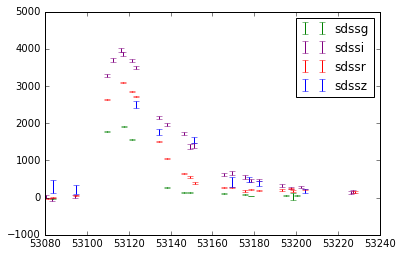

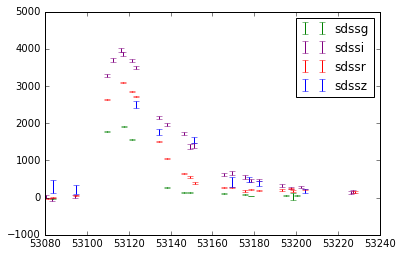

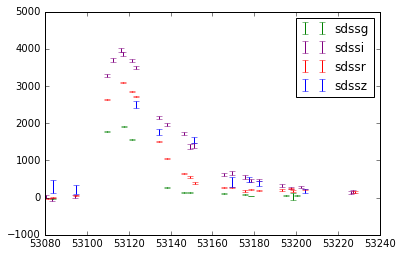

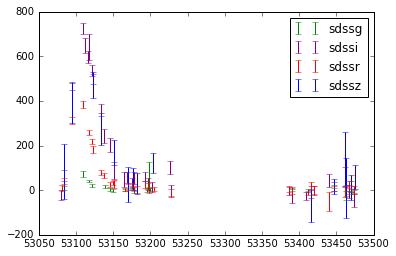

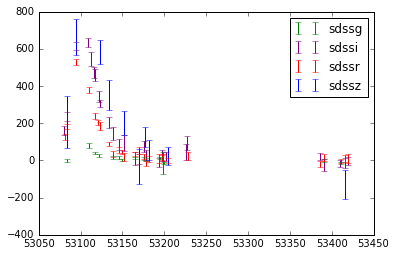

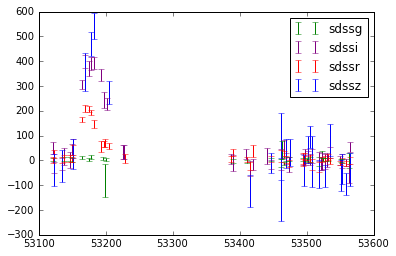

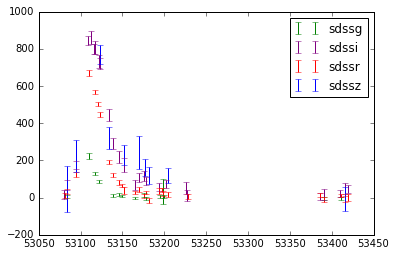

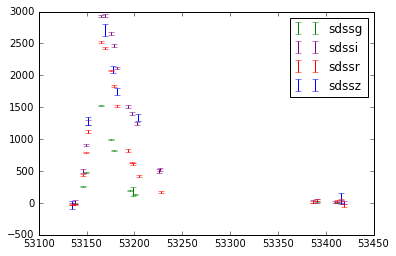

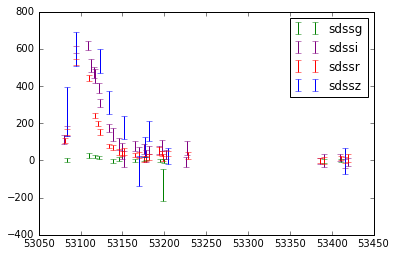

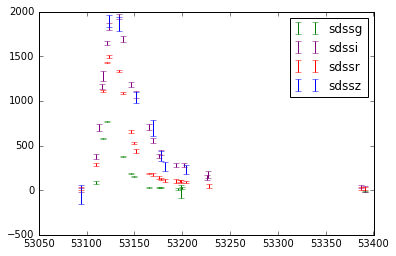

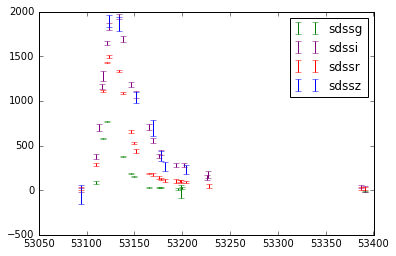

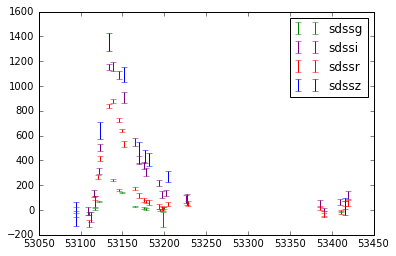

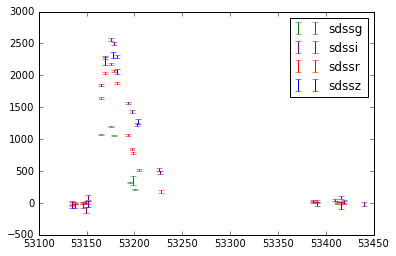

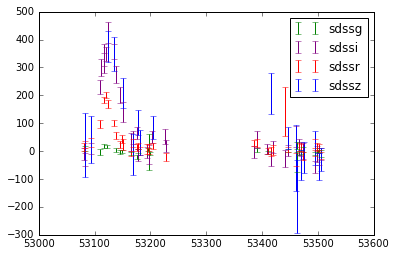

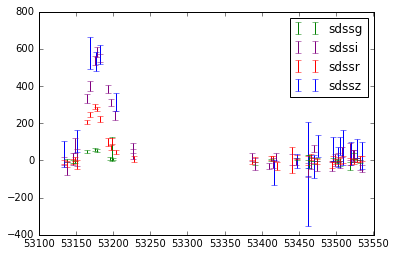

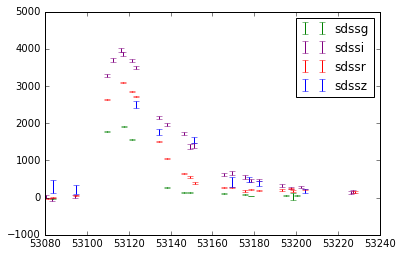

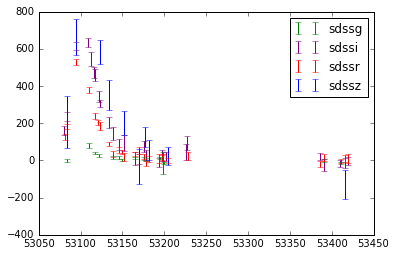

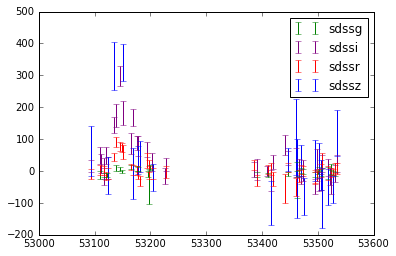

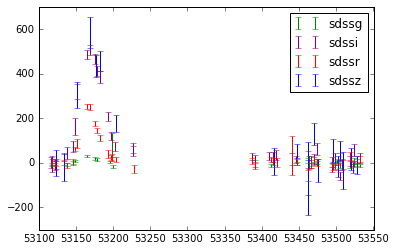

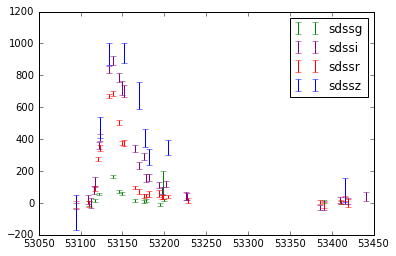

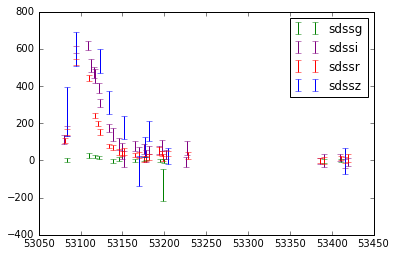

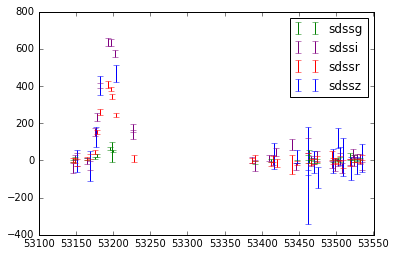

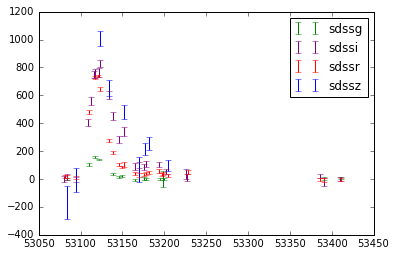

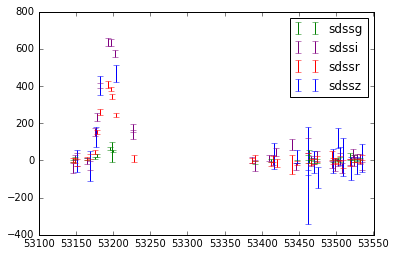

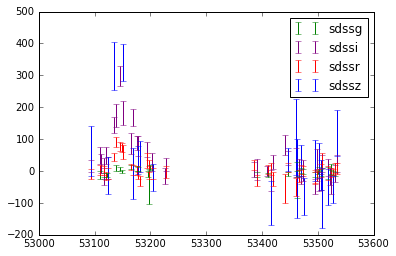

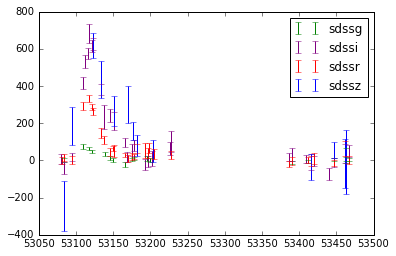

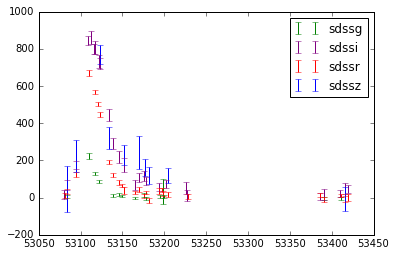

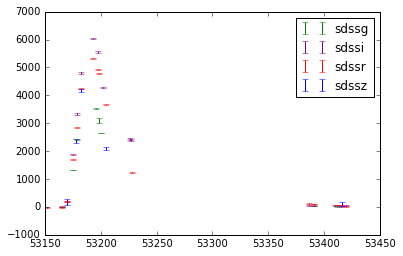

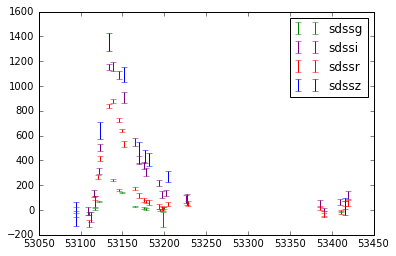

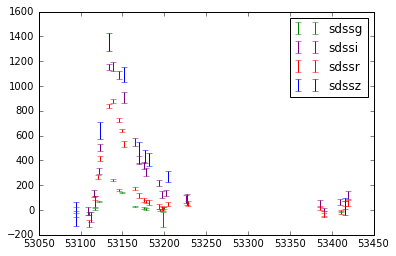

In [37]:
for sn in a:
    plot_lc(sn[0])
    print "======"

In [36]:
len(a)

30